### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ###

### Final Course Project: Due 5/5/23

# Optimizing Suburban Home Construction with Built-in Delay Uncertainty #

#### Ben Hayum (bhayum@wisc.edu)


*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

The application of optimization that I'd like to explore is calculating what the optimal construction plan is for a suburban home such that it can be completed in the minimum the amount of days possible. In order to accomplish this, I will need to just not use an estimate for how long each task in the process takes and what previous tasks need to be completed before starting each task, but I also need to build in uncertainty for when delays may occur. In order to do this, I will specify the bounds for how much weather, labor, and material delays may affect a particular task and specify a delay rate hyperparameter that will determine the probability of any particular delay happening. If a delay is randomly selected via this method then a random integer of days delayed will be selected within the specified bounds and added to the tasks's total duration.

My Father has been a residential home contractor for over 35 years. Over that time he has built a strong intuition for what processes need to happen in what order in order to build the home in the shortest amount of time. It will likely be hard to match this. However, I would love if using this project I can create a generalizeable model which he can use to figure out the optimal plans and schedules that makes his business operate faster. From working with him on the construction sites for several summers, I have some idea of what particular bottlenecks are the worst to deal with.

The hope for this model is to be easily understandable so that my father can simply input the parameters into an excell sheet and press run to find an optimal construction plan. Despite the large odds against me due to my Dad's technological illiteracy, I will try to make the process as transparent as possible.

The data for the model will be coming from estimates that I form from conversation with my Father. I will need to parse out how long average different tasks take as well as the bounds for how bad weather, labor, or material delays may be. I will also need to parse out the ordering of the different tasks to create some sort of flow chart.

The rest of this paper will elucidate the mathematical model, the solution I create, then finally the results of the solution and what they points towards.

## 2. Mathematical model ##

From this screenshot of the excel sheet you imagine a flow chart of the construction process that we will be modeling similar to what we saw early on in class. Note that the numbers used are simply one example of what you can specify in the excel sheet pipeline. These can be adjusted to any particular set of circumstances and here represent my best estimate of what I could parse out from conversation with my father.

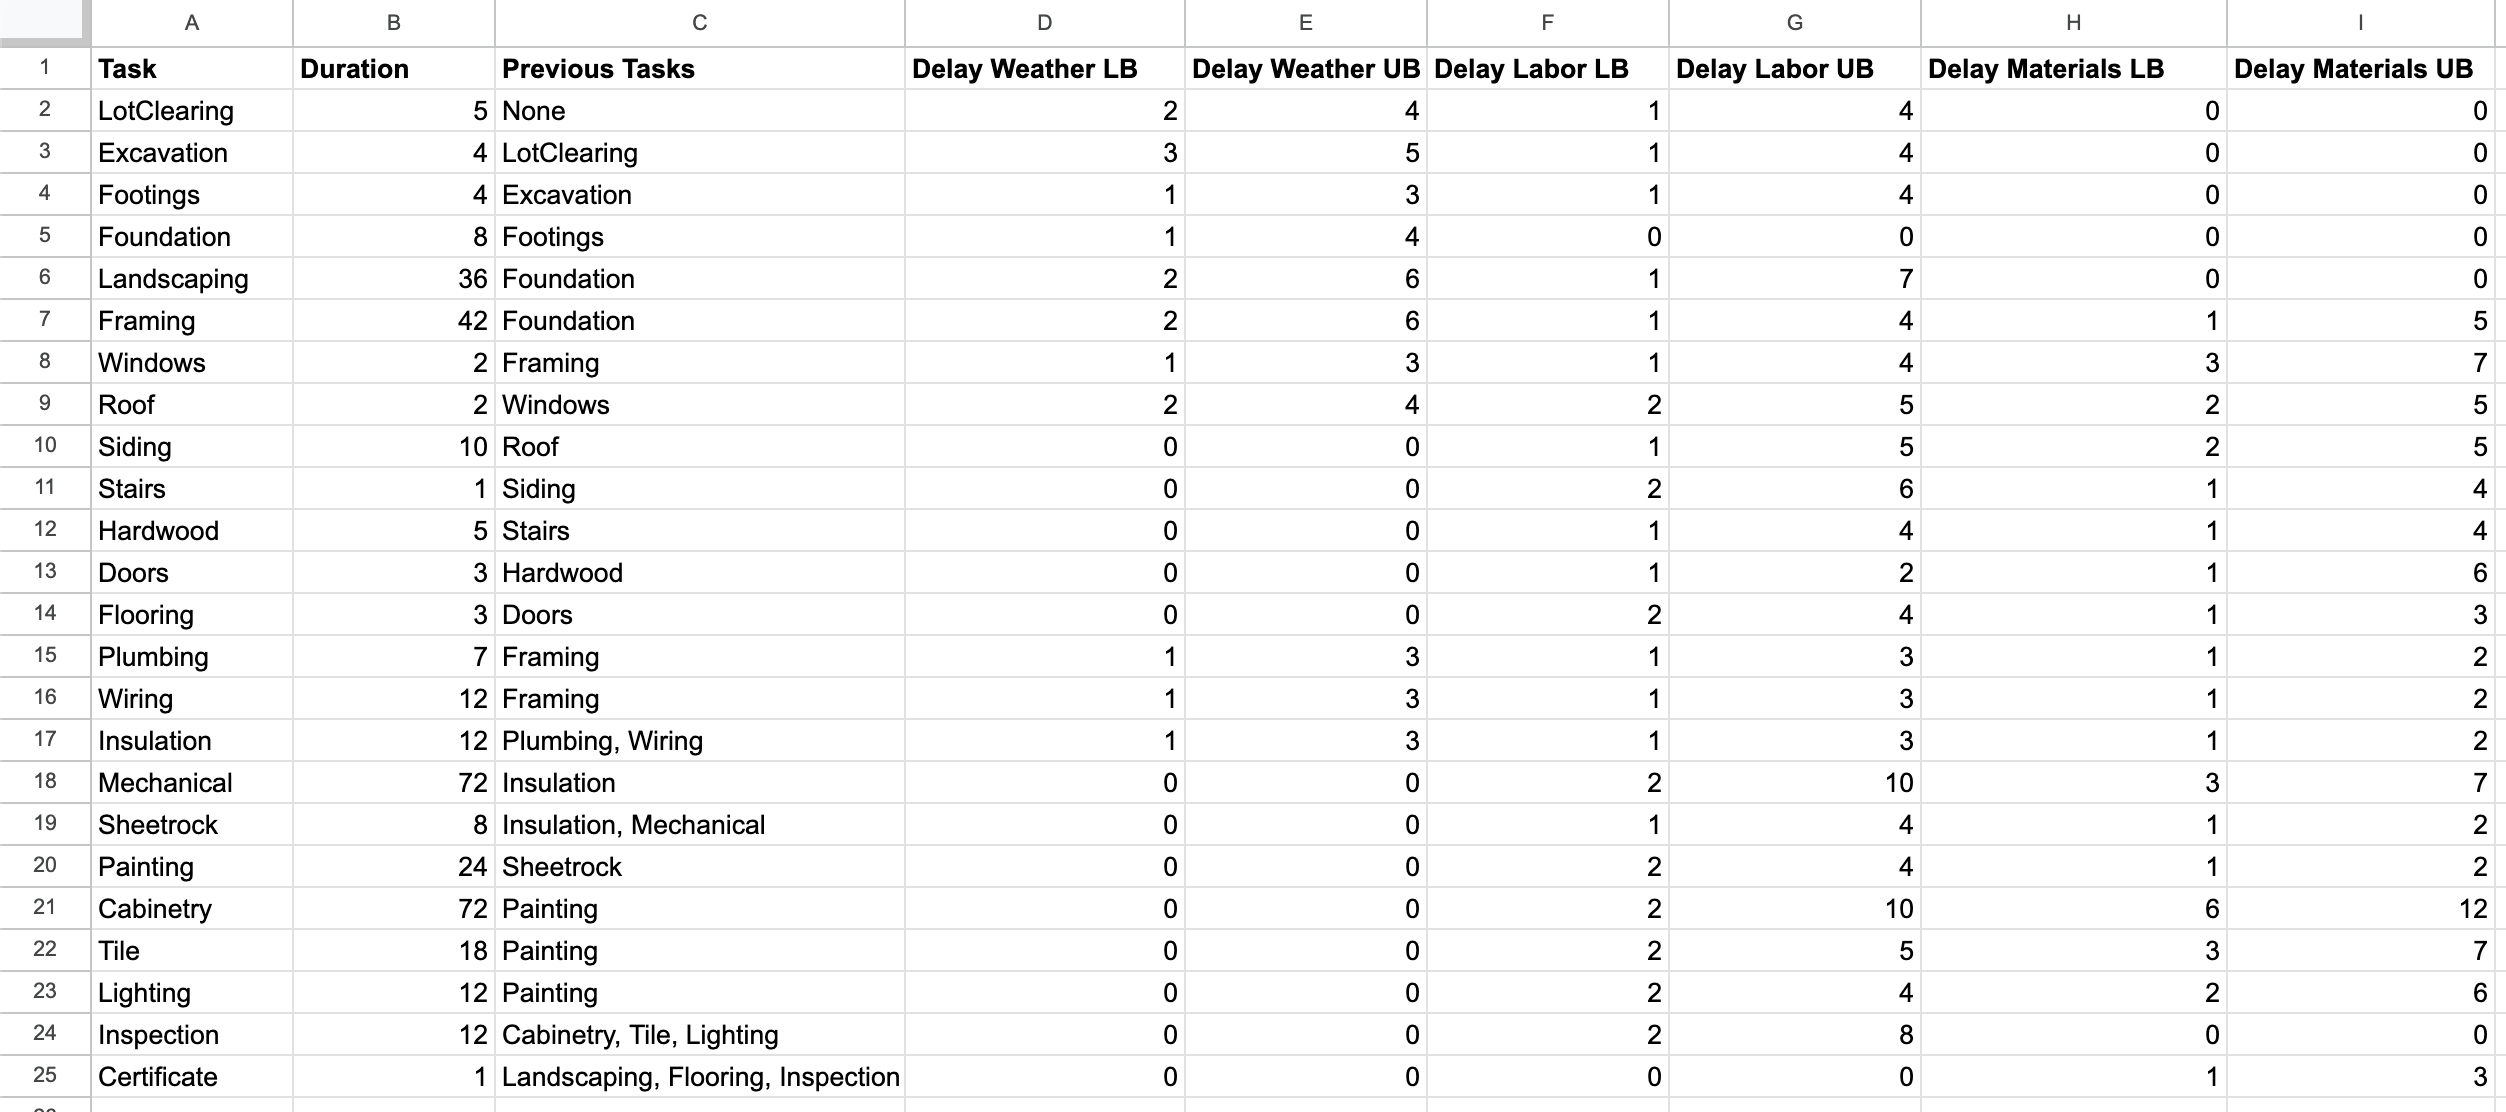

The model used to optimize this construction process will be a linear program and is specified below:

Decision variables:  
- Start time of the task $t_i$ for all tasks $i \in \mathcal{T}$, where $\mathcal{T}$ is the set of all tasks.
- Note that the final task in the model, referred to as the finish task $t_x$, is the certificate of occupancy.

Constraints:  
- Each task can only start when the previous task is done,  
$$t_i \geq t_j + d_j + r_j\quad \forall j \in  \mathcal{P}_i \quad \forall i \in\mathcal{T}$$
where $\mathcal{P}_i$ is the set of all tasks that must be finished before task $i$ can start (i.e., predecessor tasks), $d_j$ is the duration of task $j$, and $r_j$ is the summed weather, labor, and material randomly generated delay within the specified bounds from the task $j$.

- The first task will start at time 0, i.e.,
$$t_a == 0$$

Randomly Generated Delays:
- A specified delay rate, $0 \leq \lambda \leq 1$, will be the probability that any individual particular delay comes into effect. That is, within one task, since there are three possible delay causes, there will be three independent opportunities for delay due to this hyperparameter to come into effect
- If the delay is chosen to come into effect, then an integer day delay count will randomly be chosen between the specified lower and upper bounds of delay time effects for its corresponding particular task 
- Put mathematically, the delays are $\mathcal{U}_{j1}\{a, b\}$ for weather delays, $\mathcal{U}_{j2}\{c, d\}$ for labor delays, $\mathcal{U}_{j3}\{e, f\}$ for material delays, with the two internal variables being the specified lower and upper bounds
- After randomly chosing the delay times for a particular task from this method, each individual delay will be summed to create the total delay $r_j$ for a particular task $j$. This randomization will all be done prior to the model instantiation


Objective:  
$$\min_{t} t_x + d_x + r_x$$
- where $t_x$, $d_x$, and $r_x$ are the start time, duration, and delay of the finish task, respectively. 

Put into standard form:
$$\min_{t} t_x + d_x + r_x$$
$$\text{subject to: }$$ 
$$t_i \geq t_j + d_j + r_j\quad \forall j \in  \mathcal{P}_i \quad \forall i \in\mathcal{T}$$
$$r_j == \mathcal{U}_{j1}\{a, b\} + \mathcal{U}_{j2}\{c, d\} + \mathcal{U}_{j3}\{e, f\}\quad \forall j \in  \mathcal{P}_i$$
$$t_a == 0$$

Model Assumptions: 
- The average durations it takes to complete a certain task are rough estimates coming from my father and are not precise
- In order to simplify the delay uncertainty, we assume that each delay has a specified $\lambda$ probability of happening for every single task. This constant probability is clearly not the realistic case across the board and in reality there will be different probabilities of a delay dependent for the combination of each specific delay type and each task. Additionally, these will simply practically vary due to whatever the economic state of the world is at the time. Perhaps in March there is a big plywood shortage and perhaps in April there is a big window shortage. There is no way to model the randomness of the economy here besides through this simplification.
- We randomly select the delay time within the specified bounds with each integer in those bounds having an equal chance of being selected. This is also isn't perfectly accurate and in an ideal world we would better be able to model the delay distributions for each specific delay type and delay task

## 3. Solution ##

#### Demonstrating the functionality with one pass through

In [1]:
import Pkg
Pkg.add("Distributions")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using CSV
using DataFrames
df = CSV.read("HouseSchedule.csv", DataFrame)

Row,Task,Duration,Previous Tasks,Delay Weather LB,Delay Weather UB,Delay Labor LB,Delay Labor UB,Delay Materials LB,Delay Materials UB
,String15,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64
1,LotClearing,5,None,2,4,1,4,0,0
2,Excavation,4,LotClearing,3,5,1,4,0,0
3,Footings,4,Excavation,1,3,1,4,0,0
4,Foundation,8,Footings,1,4,0,0,0,0
5,Landscaping,36,Foundation,2,6,1,7,0,0
6,Framing,42,Foundation,2,6,1,4,1,5
7,Windows,2,Framing,1,3,1,4,3,7
8,Roof,2,Windows,2,4,2,5,2,5
9,Siding,10,Roof,0,0,1,5,2,5


In [3]:
tasks = []
dur = [] 
pre = []
delay = []

for i in 1:size(df)[1]
    push!(tasks, df[i, 1])
    push!(dur, df[i, 2]) 
    push!(pre, split(df[i, 3], ", "))
    push!(delay, [df[i, 4] df[i, 5]; df[i, 6] df[i, 7]; df[i, 8] df[i, 9]])
end

# Zipping them into easily usable dictionaries:
task2duration = Dict(zip(tasks,dur));
task2predecessor = Dict(zip(tasks,pre));
task2delaybounds = Dict(zip(tasks,delay));

In [4]:
using Distributions

# Getting random delays for each task 
# Rate for each individual delay happening will be the following rate:
lambda = 0.33
total_delay = []

for i in tasks
    set_of_bounds = task2delaybounds[i]
    delay_sum = 0
    # Iterating through every set of bounds for every type of delay for a given task
    # Sum across all of delays for a task to create the total delay 
    for j in 1:size(set_of_bounds)[1]
        if rand(Uniform(0, 1)) <= lambda
            curr_bounds = set_of_bounds[j, :]
            curr_delay = rand(curr_bounds[1]:curr_bounds[2])
            delay_sum += curr_delay
        end
    end
    push!(total_delay, delay_sum)
end

task2delay = Dict(zip(tasks,total_delay));   
task2delay;

In [5]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)

# Solving the model given the above delays
@variable(m, tstart[tasks])
for i in tasks
    for j in task2predecessor[i]
        if j != "None"
            @constraint(m, tstart[i] >= tstart[j] + task2duration[j] + task2delay[j])
        end
    end
end
@constraint(m, tstart["LotClearing"] == 0) # start time of the first task
@objective(m, Min, tstart["Certificate"] + task2duration["Certificate"] + task2delay["Certificate"]) # end time of the last task

optimize!(m)

for i in tasks
    println(i, ": ", abs(value(tstart[i])))
end
    
println()
println("minimum duration: ", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
28 rows, 22 cols, 55 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-30); columns 0(-24); elements 0(-59) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  2.9800000000e+02
HiGHS run time      :          0.00
LotClearing: 0.0
Excavation: 5.0
Footings: 14.0
Foundation: 23.0
Landscaping: 33.0
Framing: 33.0
Windows: 77.0
Roof: 79.0
Siding: 84.0
Stairs: 94.0
Hardwood: 99.0
Doors: 104.0
Flooring: 109.0
Plumbing: 77.0
Wiring: 77.0
Insulation: 89.0
Mechanical: 103.0
Sheetrock: 175.0
Painting: 183.0
Cabinetry: 207.0
Tile: 207.0
Lighting: 207.0
Inspection: 279.0
Certificate: 297.0

minimum duration: 298.0


#### Function to call model any number of iterations specified at a given delay rate and find minimum duration
To be used in 4.A of the results section

In [6]:
using Distributions
using JuMP, HiGHS
using Plots

function optimal_durations(iterations, lambda)
    minimum_duration = []
    for iteration in 1:iterations
        # Getting random delays for each task 
        # Rate for each individual delay happening will be the following rate:
        delay_rate = lambda
        total_delay = []

        for i in tasks
            set_of_bounds = task2delaybounds[i]
            delay_sum = 0
            # Iterating through every set of bounds for every type of delay for a given task
            # Sum across all of delays for a task to create the total delay 
            for j in 1:size(set_of_bounds)[1]
                if rand(Uniform(0, 1)) <= delay_rate
                    curr_bounds = set_of_bounds[j, :]
                    curr_delay = rand(curr_bounds[1]:curr_bounds[2])
                    delay_sum += curr_delay
                end
            end
            push!(total_delay, delay_sum)
        end
        task2delay = Dict(zip(tasks,total_delay));   

        m = Model(HiGHS.Optimizer)
        set_silent(m)
        # Solving the model given the above delays
        @variable(m, tstart[tasks])
        for i in tasks
            for j in task2predecessor[i]
                if j != "None"
                    @constraint(m, tstart[i] >= tstart[j] + task2duration[j] + task2delay[j])
                end
            end
        end
        @constraint(m, tstart["LotClearing"] == 0) # start time of the first task
        @objective(m, Min, tstart["Certificate"] + task2duration["Certificate"] + task2delay["Certificate"]) # end time of the last task

        optimize!(m)
        push!(minimum_duration, objective_value(m))
    end
    
    return minimum_duration
end;

#### Function used to return one set of  optimal starting days for each task at a given delay rate
To be used in 4.B of the results section

In [7]:
using Distributions
using JuMP, HiGHS
using Plots

function optimal_plan(lambda)
    # Getting random delays for each task 
    # Rate for each individual delay happening will be the following rate:
    delay_rate = lambda
    total_delay = []

    for i in tasks
        set_of_bounds = task2delaybounds[i]
        delay_sum = 0
        # Iterating through every set of bounds for every type of delay for a given task
        # Sum across all of delays for a task to create the total delay 
        for j in 1:size(set_of_bounds)[1]
            if rand(Uniform(0, 1)) <= delay_rate
                curr_bounds = set_of_bounds[j, :]
                curr_delay = rand(curr_bounds[1]:curr_bounds[2])
                delay_sum += curr_delay
            end
        end
        push!(total_delay, delay_sum)
    end
    task2delay = Dict(zip(tasks,total_delay));   

    m = Model(HiGHS.Optimizer)
    set_silent(m)
    # Solving the model given the above delays
    @variable(m, tstart[tasks])
    for i in tasks
        for j in task2predecessor[i]
            if j != "None"
                @constraint(m, tstart[i] >= tstart[j] + task2duration[j] + task2delay[j])
            end
        end
    end
    @constraint(m, tstart["LotClearing"] == 0) # start time of the first task
    @objective(m, Min, tstart["Certificate"] + task2duration["Certificate"] + task2delay["Certificate"]) # end time of the last task

    optimize!(m)
    plan = ""
    for i in tasks
        plan = plan * "\n" * string(i, ": ", abs(value(tstart[i])))
    end
    
    return plan
end;

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.


### 4.A Generating Optimal Construction Time Distributions with Different Delay Rates

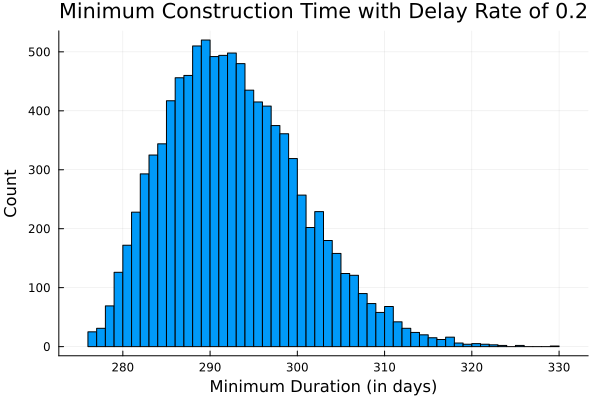

In [8]:
iterations = 10000
lambda = 0.2
minimum_duration = optimal_durations(iterations, lambda)

histogram(minimum_duration, legend=false, 
    xlabel="Minimum Duration (in days)", 
    ylabel="Count", 
    title="Minimum Construction Time with Delay Rate of 0.2")

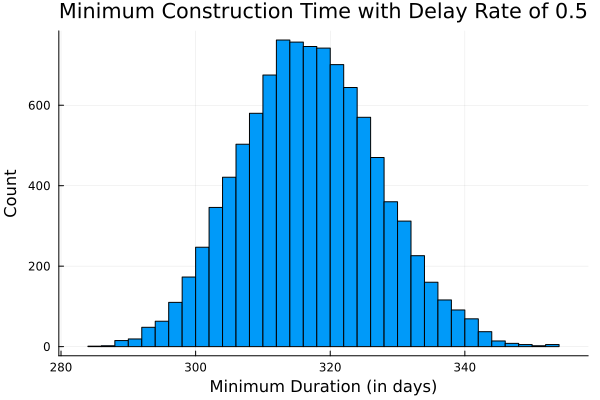

In [9]:
iterations = 10000
lambda = 0.5
minimum_duration = optimal_durations(iterations, lambda)

histogram(minimum_duration, legend=false, 
    xlabel="Minimum Duration (in days)", 
    ylabel="Count", 
    title="Minimum Construction Time with Delay Rate of 0.5")

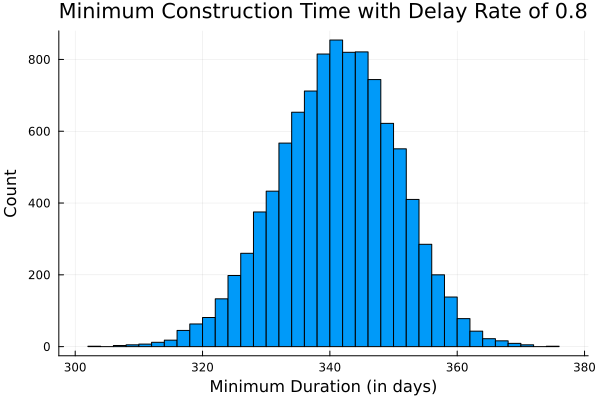

In [10]:
iterations = 10000
lambda = 0.8
minimum_duration = optimal_durations(iterations, lambda)

histogram(minimum_duration, legend=false, 
    xlabel="Minimum Duration (in days)", 
    ylabel="Count", 
    title="Minimum Construction Time with Delay Rate of 0.8")

With a delay rate of 0.2, the minimum construction duration is about 290 days on average.
___
With a delay rate of 0.5, the minimum construction duration is about 315 days on average.
___
With a delay rate of 0.8, the minimum construction duration is about 340 days on average.
___

The bigger the delay rate, the more the distribution seemed to vary as the histograms became wider.
However, the small the delay rate, the more tailed the distributions appeared to be.
___
These results seem about right. The construction process for a new suburban home generally takes somewhere around a little bit less than a year. Given how mild or horrible the delays during a home construction process can be, a difference of 50 days also seems about right.


### 4.B Generating Example Plans

In [11]:
lambda = 0.2
print("Example Optimal Days to start each task with Delay Rate of 0.2\n", optimal_plan(lambda))

Example Optimal Days to start each task with Delay Rate of 0.2

LotClearing: 0.0
Excavation: 9.0
Footings: 15.0
Foundation: 25.0
Landscaping: 33.0
Framing: 33.0
Windows: 75.0
Roof: 77.0
Siding: 79.0
Stairs: 89.0
Hardwood: 90.0
Doors: 99.0
Flooring: 108.0
Plumbing: 75.0
Wiring: 75.0
Insulation: 88.0
Mechanical: 103.0
Sheetrock: 187.0
Painting: 195.0
Cabinetry: 219.0
Tile: 219.0
Lighting: 219.0
Inspection: 301.0
Certificate: 313.0

In [12]:
lambda = 0.5
print("Example Optimal Days to start each task with Delay Rate of 0.5\n", optimal_plan(lambda))

Example Optimal Days to start each task with Delay Rate of 0.5

LotClearing: 0.0
Excavation: 12.0
Footings: 17.0
Foundation: 25.0
Landscaping: 33.0
Framing: 33.0
Windows: 79.0
Roof: 87.0
Siding: 91.0
Stairs: 102.0
Hardwood: 107.0
Doors: 118.0
Flooring: 125.0
Plumbing: 79.0
Wiring: 79.0
Insulation: 95.0
Mechanical: 110.0
Sheetrock: 189.0
Painting: 201.0
Cabinetry: 226.0
Tile: 226.0
Lighting: 226.0
Inspection: 298.0
Certificate: 310.0

In [13]:
lambda = 0.8
print("Example Optimal Days to start each task with Delay Rate of 0.8\n", optimal_plan(lambda))

Example Optimal Days to start each task with Delay Rate of 0.8

LotClearing: 0.0
Excavation: 8.0
Footings: 19.0
Foundation: 26.0
Landscaping: 35.0
Framing: 35.0
Windows: 80.0
Roof: 86.0
Siding: 90.0
Stairs: 109.0
Hardwood: 113.0
Doors: 126.0
Flooring: 132.0
Plumbing: 80.0
Wiring: 80.0
Insulation: 99.0
Mechanical: 113.0
Sheetrock: 188.0
Painting: 201.0
Cabinetry: 227.0
Tile: 227.0
Lighting: 227.0
Inspection: 316.0
Certificate: 336.0

Qualitatively looking at the start dates for each task above, it seems like despite start days varying due to the delay rate, the general order of when to start working on which tasks seems pretty constant. This makes sense.

When talking with my father, he had the process in his mind as one that is step-by-step, rather than a diverging and converging flow chart. I worked hard to be able to take his process and distill it into this kind of flow chart. However, this optimization proves that even when including diverging and converging processes, the general ordering of tasks remains the same. This likely validates my father's methods that even with randomly occuring delays, there does seem to be a relatively constant order to get tasks done.

### 4.C Limitations
As discussed in the Mathematical Model Specification, there were some assumptions which do not perfectly hold up to a first principles analysis of what causal variables affect construction times. Here are those repeated:

- The average durations it takes to complete a certain task are rough estimates coming from my father and are not precise
- In order to simplify the delay uncertainty, we assume that each delay has a specified $\lambda$ probability of happening for every single task. This constant probability is clearly not the realistic case across the board and in reality there will be different probabilities of a delay occuring for the combination of each specific delay type and each task. Additionally, these will simply practically vary due to whatever the economic state of the world is at the time. Perhaps in March there is a big plywood shortage and perhaps in April there is a big window shortage. There is no way to model the randomness of the economy here besides through this simplification.
- We randomly select the delay time within the specified bounds with each integer in those bounds having an equal chance of being selected. This is also isn't perfectly accurate and in an ideal world we would better be able to model the delay distributions for each specific delay type and delay task.

The results of the model are biased as a result of these assumptions. However, it seems very difficult to be able to model the randomness of the construction process and all the variables included besides through a simplification similar to this.

## 5. Conclusion ##

In summary, different delay rates created different distributions of optimal construction times which resembled how long my father reported his construction times to take. Changing the delay rate from 0.2 to 0.8 created an average optimal construction time difference of 50 days which also resembled how much of the effect getting very lucky vs unlucky has on the process. Sadly, the optimal ordering of tasks to perform did not vary much across the different delay rates, so the model doesn't have much power in helping make the process faster. However, this result did support what my father qualitatively told me which that construction is largely a process with the same step-by-step tasks every time and that isn't much improvising of this order. 

The project overall had several limitations of how accurately we could model the randomness with which delays occur. For example, there is no one statistical distribution such as a gaussian or poisson that we can particularly use to model what material shortages or weather patterns may look like. An interesting future direction for this work could be to track the soon upcoming weather and material shortages online and factor this into the model. This would allow the delay randomness to be much more grounded in present reality than could be accomplished with the simplifications here.

Overall, if my father ever wanted some way to model uncertainty in how long a project may take, all he would have to do is input some numbers into an excel sheet and press run on this notebook to get ballpark estimates. In this sense, the model did its job.